# Imports

In [28]:
import os
import numpy as np
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
warnings.filterwarnings("ignore")
pd.set_option("display.max_rows",None)
from sklearn import preprocessing
import matplotlib
matplotlib.style.use('ggplot')
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Data & visualisations

In [29]:
import kagglehub
andrewmvd_heart_failure_clinical_data_path = kagglehub.dataset_download('andrewmvd/heart-failure-clinical-data')
fedesoriano_heart_failure_prediction_path = kagglehub.dataset_download('fedesoriano/heart-failure-prediction')

print('Data source import complete.')

df=pd.read_csv("/kaggle/input/heart-failure-prediction/heart.csv")
df.head()

Data source import complete.


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [30]:
df.shape

(918, 12)

In [31]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [32]:
# Changing the object types to string to be able to work with

string_col = df.select_dtypes(include="object").columns
df[string_col]=df[string_col].astype("string")

df.dtypes

,0
Age,int64
Sex,string[python]
ChestPainType,string[python]
RestingBP,int64
Cholesterol,int64
FastingBS,int64
RestingECG,string[python]
MaxHR,int64
ExerciseAngina,string[python]
Oldpeak,float64


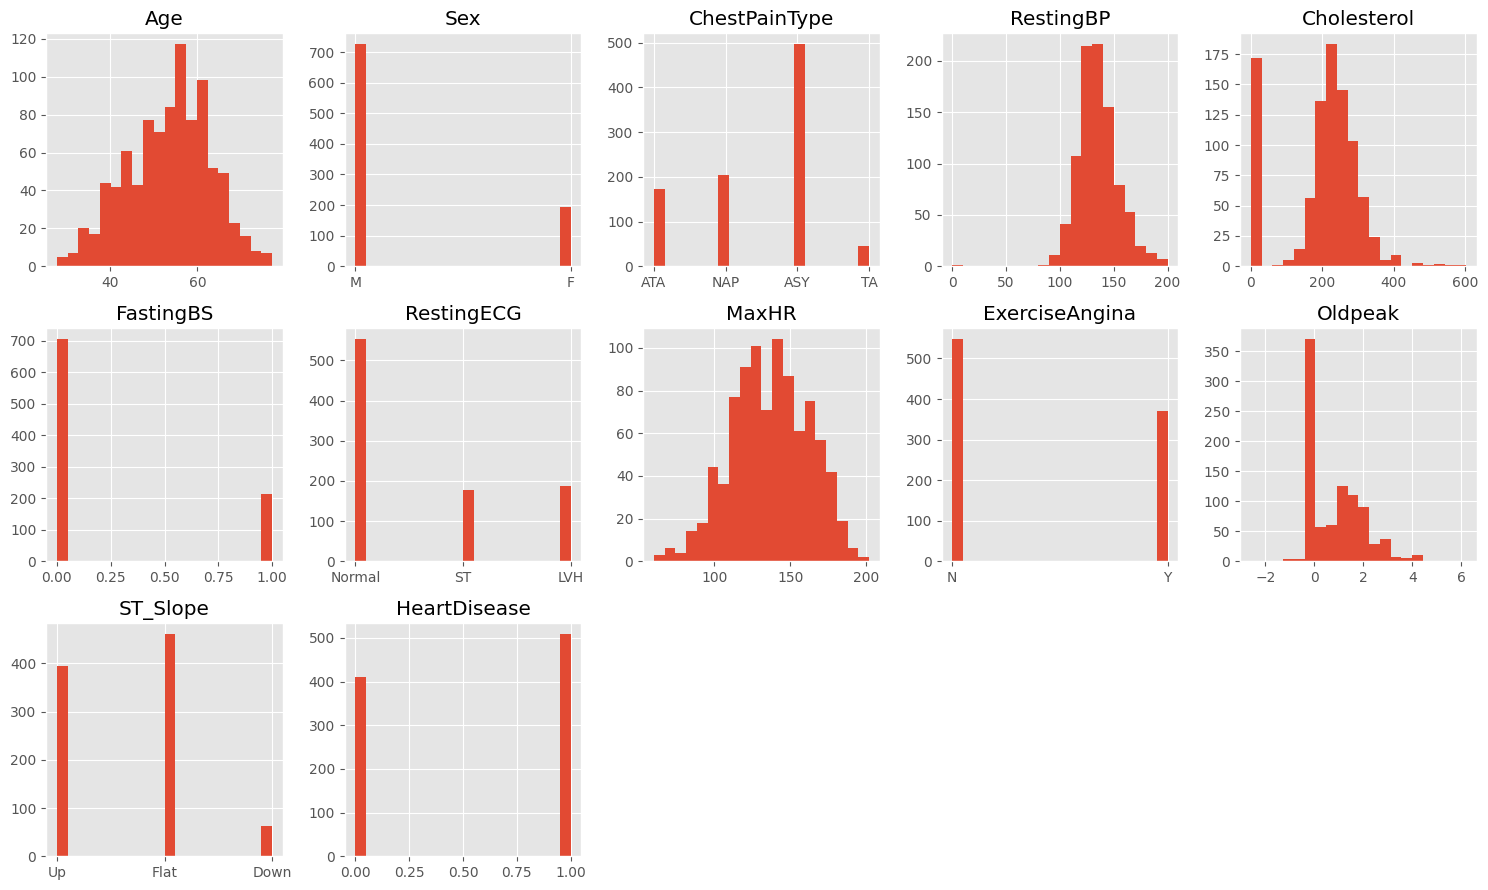

In [33]:
#Plotting the data so that we see the distributions and to get a good grasp of what we are doing

# Get the list of columns to plot
cols = df.columns
n_cols = 5
n_rows = (len(cols) + n_cols - 1) // n_cols

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 3))
axes = axes.flatten() # Flatten the axes array for easy iteration

# Plot histograms for each column in the subplots
for i, col in enumerate(cols):
    axes[i].hist(df[col], bins=20)
    axes[i].set_title(col)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

 The Attributess include:
- Age: age of the patient [years]
- Sex: sex of the patient [M: Male, F: Female]
- ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
- RestingBP: resting blood pressure [mm Hg]
- Cholesterol: serum cholesterol [mm/dl]
- FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
- RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
- MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
- ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
- Oldpeak: oldpeak = ST [Numeric value measured in depression]
- ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
- HeartDisease: output class [1: heart disease, 0: Normal]

# Missing value imputing

Number of data points with zero Cholesterol: 172
Mean of non-zero Cholesterol values: 244.64
Number of data points with zero Cholesterol after imputation: 0


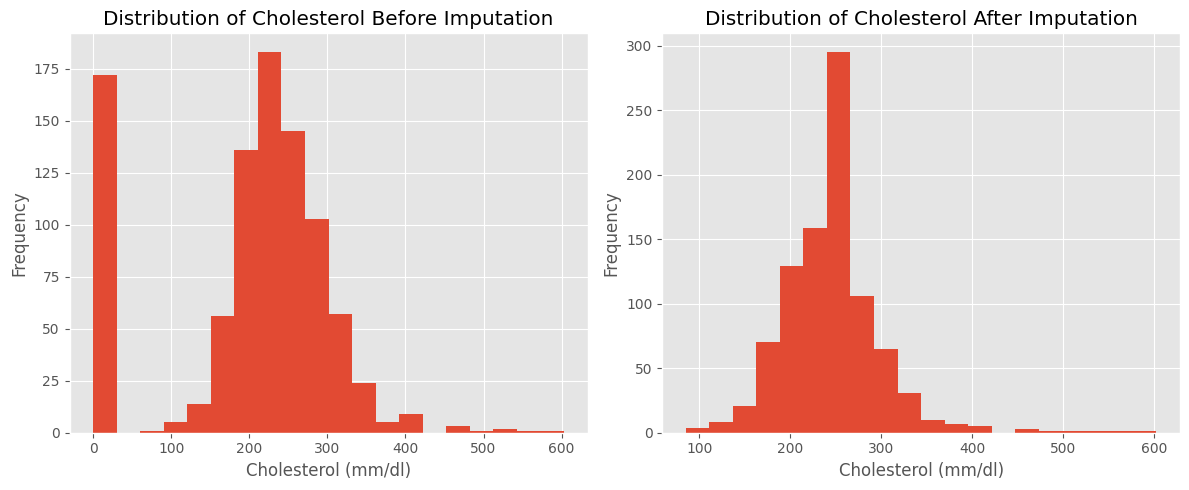

In [34]:
# Detection of the datapoints with zero cholesterol and imputing them using mean

# Count the number of rows where Cholesterol is 0
zero_cholesterol_count = df[df['Cholesterol'] == 0].shape[0]
print(f"Number of data points with zero Cholesterol: {zero_cholesterol_count}")

# Calculate the mean of the non-zero Cholesterol values
mean_cholesterol = df[df['Cholesterol'] != 0]['Cholesterol'].mean()
print(f"Mean of non-zero Cholesterol values: {mean_cholesterol:.2f}")

# Plot the distribution of Cholesterol after imputation
fig, axes = plt.subplots(1,2, figsize=(12, 5)) # Create 2 subplots (2 rows, 1 column)
axes[0].hist(df['Cholesterol'], bins=20)
axes[0].set_title('Distribution of Cholesterol Before Imputation')
axes[0].set_xlabel('Cholesterol (mm/dl)')
axes[0].set_ylabel('Frequency')


# Impute the zero Cholesterol values with the calculated mean
df['Cholesterol'] = df['Cholesterol'].replace(0, mean_cholesterol)

# Verify that there are no more zero Cholesterol values
zero_cholesterol_count_after_imputation = df[df['Cholesterol'] == 0].shape[0]
print(f"Number of data points with zero Cholesterol after imputation: {zero_cholesterol_count_after_imputation}")


# Plot the distribution of Cholesterol after imputation
axes[1].hist(df['Cholesterol'], bins=20)
axes[1].set_title('Distribution of Cholesterol After Imputation')
axes[1].set_xlabel('Cholesterol (mm/dl)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [35]:
df.shape

(918, 12)

# Pairplot

[]

<Figure size 1000x500 with 0 Axes>

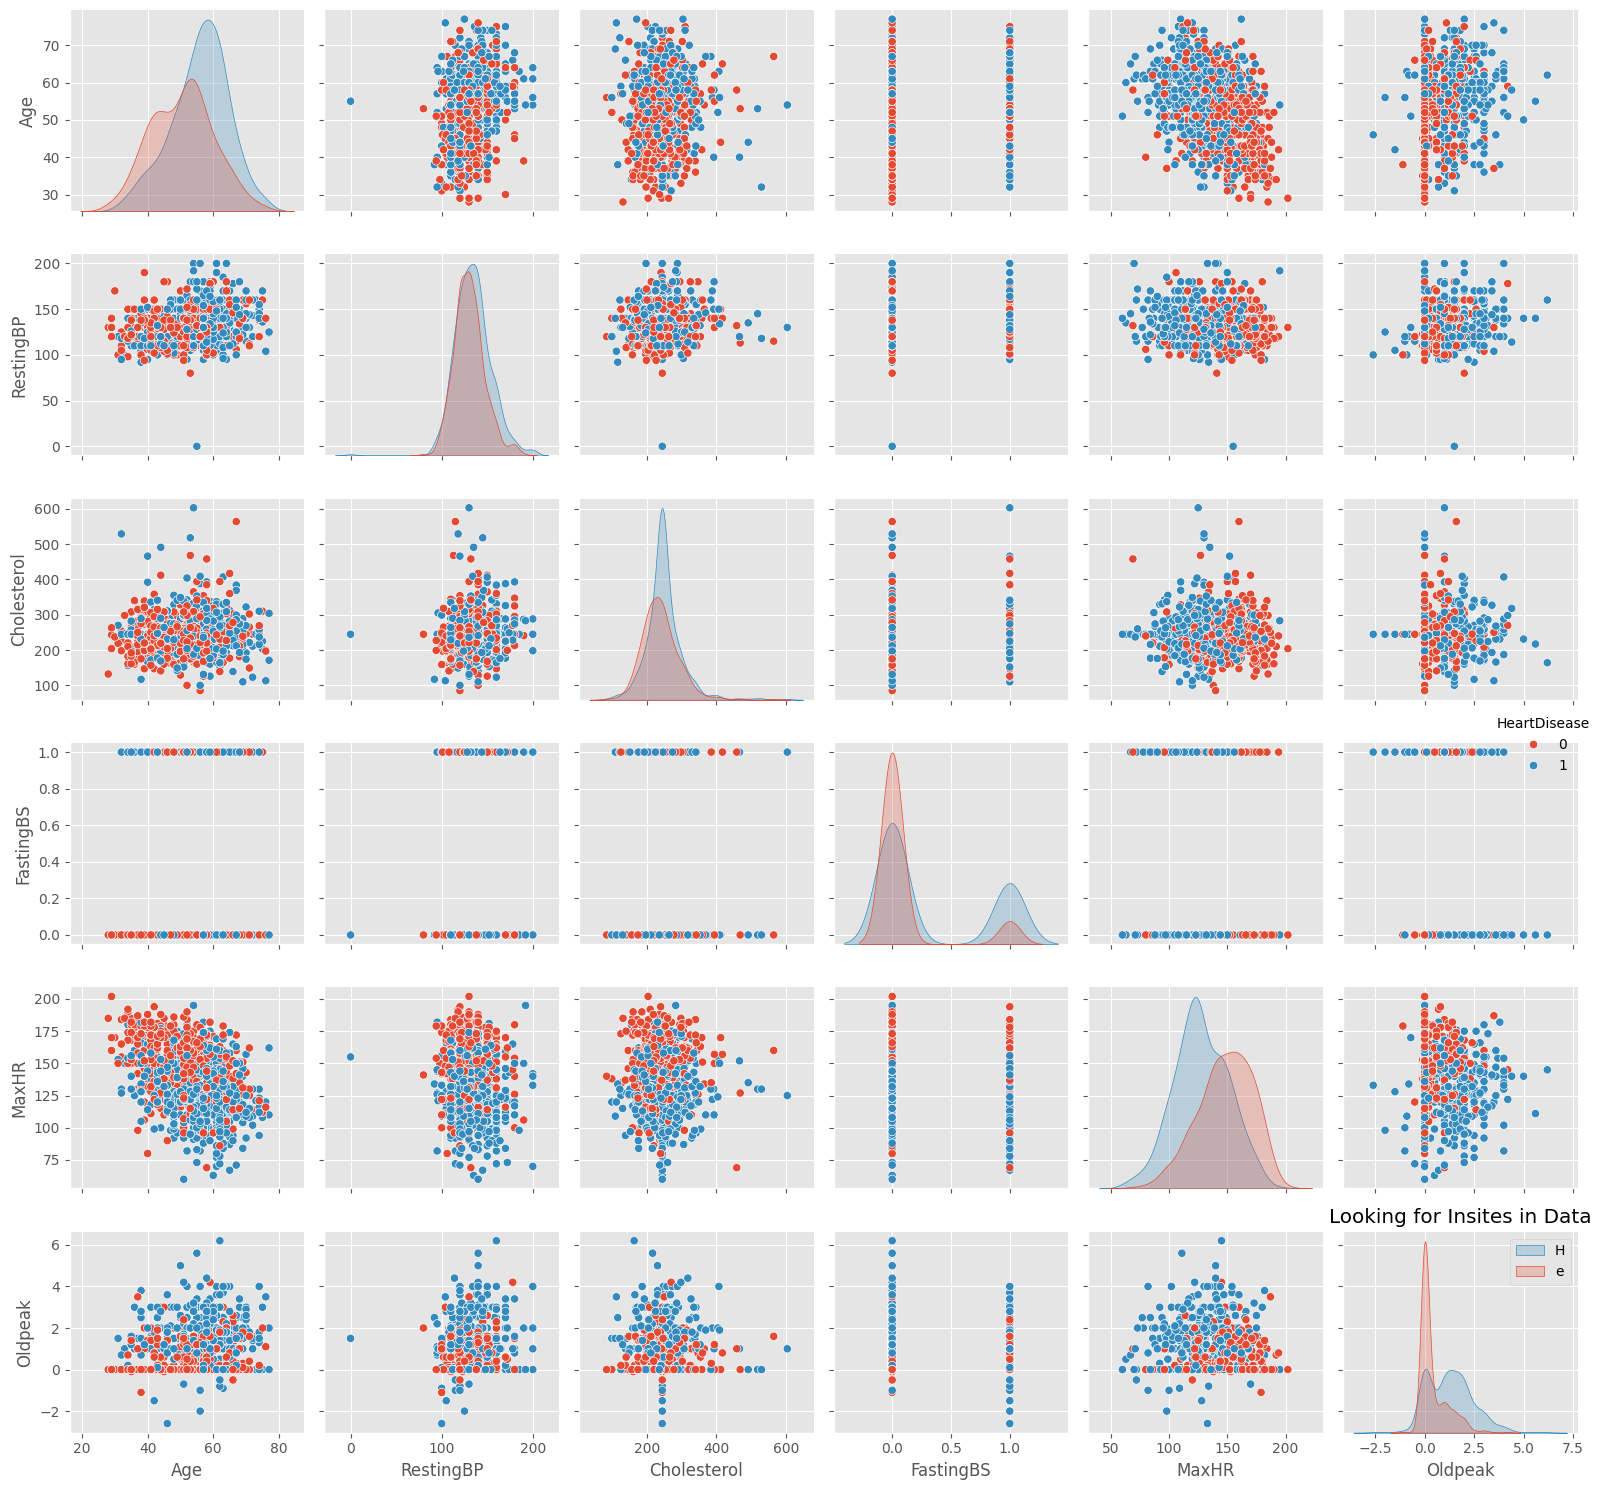

In [36]:
# Displaying Pairplot

plt.figure(figsize=(10,5))
sns.pairplot(df,hue="HeartDisease")
plt.title("Looking for Insites in Data")
plt.legend("HeartDisease")
plt.tight_layout()
plt.plot()

# One hot encoding


In [37]:
# One hot encoding the features that are of string type

# Identify string type columns
string_cols = df.select_dtypes(include='string').columns

# One-hot encode the string type columns
df = pd.get_dummies(df, columns=string_cols, drop_first=True)

df.dtypes

,0
Age,int64
RestingBP,int64
Cholesterol,float64
FastingBS,int64
MaxHR,int64
Oldpeak,float64
HeartDisease,int64
Sex_M,boolean
ChestPainType_ATA,boolean
ChestPainType_NAP,boolean


# Corr matrix

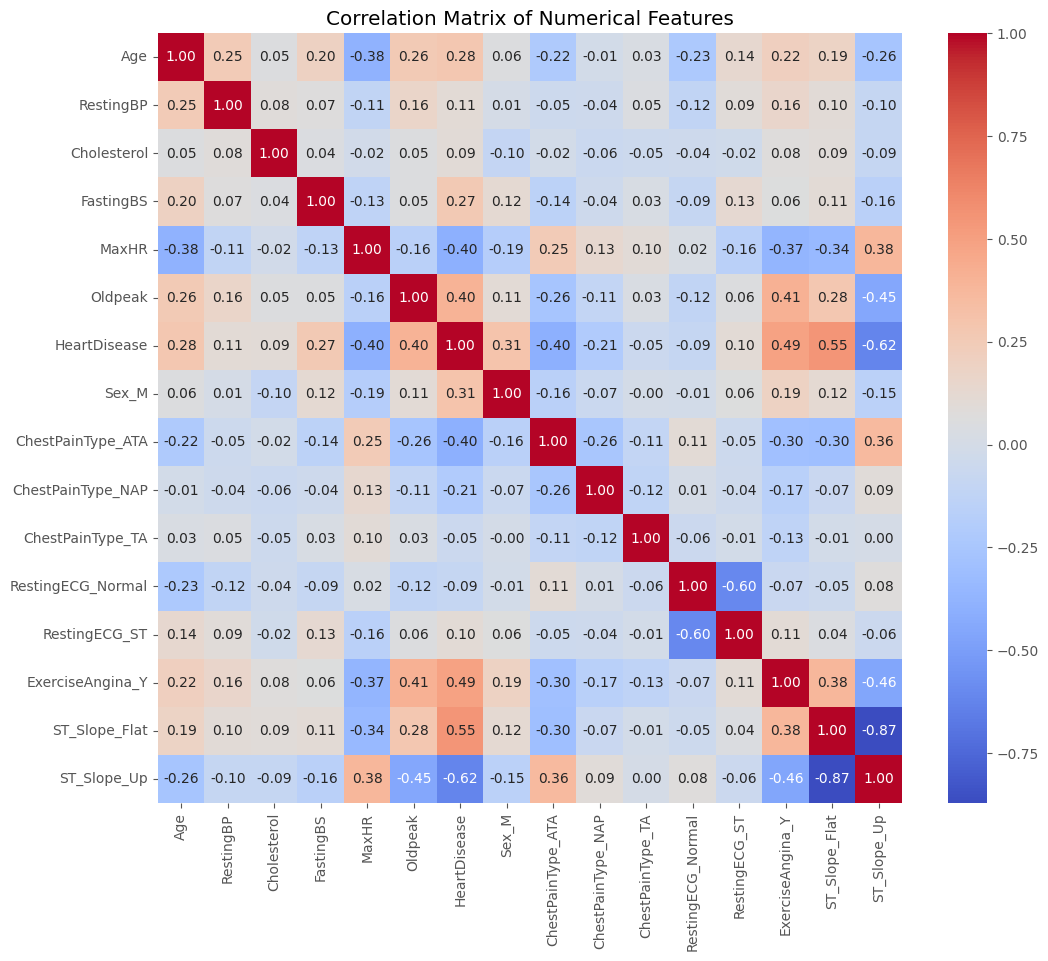

In [38]:
# Creating a correlation matrix for my data

# Select only the numerical columns for correlation calculation
numerical_df = df.select_dtypes(include=np.number)

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Plot the correlation matrix using seaborn heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# Outlier detection

In [39]:
# Outlier detection and removal using lof

features = df.drop(columns=['HeartDisease'])
lof = LocalOutlierFactor(n_neighbors=20)
outliers = lof.fit_predict(features)
df_lof = df[outliers != -1]  # remove outliers

print("\nDataset shape after removing outliers:", df_lof.shape)


Dataset shape after removing outliers: (899, 16)


# Spliting

In [40]:
# Data spliting

X_class = df_lof.drop(columns=['HeartDisease'])
y_class = df_lof['HeartDisease']
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

# Normalizing

In [41]:
# Normalizing the data

scaler = StandardScaler()
X_train_c_scaled = scaler.fit_transform(X_train_c)
X_test_c_scaled = scaler.transform(X_test_c)

# Feature selection

In [42]:
# Feature selection

selector_c = SelectKBest(score_func=f_classif, k=5)
X_train_c_selected = selector_c.fit_transform(X_train_c_scaled, y_train_c)
X_test_c_selected = selector_c.transform(X_test_c_scaled)

# Training

In [43]:
# Training

clf = RandomForestClassifier()
params_c = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5, 10]
}
grid_c = GridSearchCV(clf, param_grid=params_c, cv=3, scoring='accuracy')
grid_c.fit(X_train_c_selected, y_train_c)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [3, 5, 10], 'n_estimators': [50, 100]},
             scoring='accuracy')

# Results


Best classification parameters: {'max_depth': 5, 'n_estimators': 50}

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.84      0.77        67
           1       0.89      0.80      0.84       113

    accuracy                           0.81       180
   macro avg       0.80      0.82      0.80       180
weighted avg       0.82      0.81      0.81       180



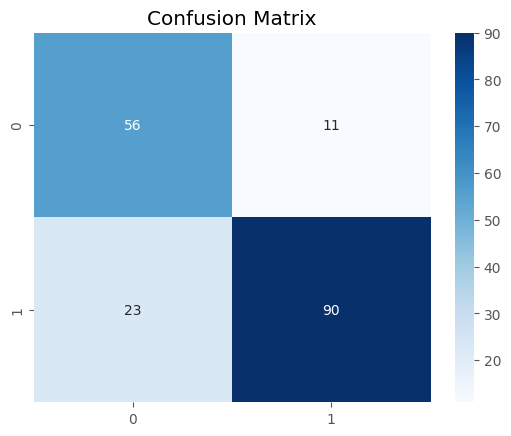

In [44]:
# Results

print("\nBest classification parameters:", grid_c.best_params_)
y_pred_c = grid_c.predict(X_test_c_selected)
print("\nClassification Report:")
print(classification_report(y_test_c, y_pred_c))
sns.heatmap(confusion_matrix(y_test_c, y_pred_c), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()
